In [1]:
#| default_exp hyperparam

In [2]:
#| export
import random, math, torch, numpy as np, matplotlib.pyplot as plt
from tinyai.model import *
from tinyai.learner import *
from tinyai.hooks import *
from tinyai.init import *
from tinyai.speedup import *
import fastcore.all as fc
from functools import partial
import time

In [3]:
#| export
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
import tiktoken
import os

enc = tiktoken.get_encoding("gpt2")

def get_tokens(input_file):
    with open(input_file) as f:
        text = f.read()
    tokens = enc.encode(text)
    return tokens

cwd = os.getcwd()
input_file = f"{cwd}/fast-nanogpt/input.txt"
tokens = get_tokens(input_file)
train, valid = tokens[:int(len(tokens)*0.8)], tokens[int(len(tokens)*0.8):]

In [5]:
class LoopingDataSet:
    def __init__(self, tokens, n=500, T=32):
        self.tokens = tokens
        self.T = T
        self.n = n
        self.current_pos = 0

    def __len__(self):
        return self.n

    def __getitem__(self, i):
        if self.current_pos + self.T + 1 >= len(self.tokens):
            self.current_pos = 0

        x = self.tokens[self.current_pos : self.current_pos + self.T]
        y = self.tokens[self.current_pos + 1 : self.current_pos + self.T + 1]
        self.current_pos += self.T
        return x, y

In [6]:
tds = LoopingDataSet(torch.tensor(train), n=200, T=512)
# vds = DataSet(torch.tensor(valid))
dls = DataLoaders.from_dd([tds, None], batch_size=4)
# dls = DataLoaders.from_dd([tds, vds], batch_size=4)
x, y = next(iter(dls.train))
x.shape, y.shape, len(tds), len(dls.train)

(torch.Size([4, 512]), torch.Size([4, 512]), 200, 50)

## Adam optimizer, and gradient clipping
GPT-2 weights are available, but the paper does not say much about training. GPT-3 paper provides more details about training, but the weights are not available. The two models have similar architecture, so we can use GP-3 training details to train GPT-2.
> To train all versions of GPT-3, we use Adam with β1 = 0.9, β2 = 0.95, and = 10−8, we clip the global norm of the gradient at 1.0

In [7]:
admw = partial(optim.AdamW, betas=(0.9, 0.95), eps=1e-8)

By clip the global norm, it means that we take the norm of all the gradients and if it is greater than a certain value, we scale all the gradients so that the norm is equal to the value we want. This is a way to prevent the gradients from exploding. 

In [8]:
from torch.linalg import vector_norm
grads = torch.arange(9, dtype=float) - 4
norm = grads.square().sum().sqrt()
grads, norm, vector_norm(grads)

(tensor([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.], dtype=torch.float64),
 tensor(7.7460, dtype=torch.float64),
 tensor(7.7460, dtype=torch.float64))

In [9]:
max_grad_norm = 1.0
coeff = max_grad_norm / (norm + 1e-6)
coeff = torch.clamp(coeff, max=1.0)
coeff, grads * coeff, vector_norm(grads * coeff)

(tensor(0.1291, dtype=torch.float64),
 tensor([-0.5164, -0.3873, -0.2582, -0.1291,  0.0000,  0.1291,  0.2582,  0.3873,
          0.5164], dtype=torch.float64),
 tensor(1.0000, dtype=torch.float64))

In [10]:
#| export
class NormGradTrainCB(MixedPrecisionTrainCB):

    def backward(self, learn):
        learn.loss.backward()
        learn.grad_nom = nn.utils.clip_grad_norm_(learn.model.parameters(), 1.0)


## Learning rate schedule
> and we use cosine decay for learning rate down to 10% of its value, over 260 billion tokens (after 260 billion tokens, training continues at 10% of the original learning rate). There is a linear LR warmup over the first 375 million tokens.

In [11]:
def plot_func(func, x_range=(-2, 2), n_points=100):
    x = np.linspace(x_range[0], x_range[1], n_points)
    y = [func(i) for i in x]
    plt.plot(x, y)
    # plt.show()

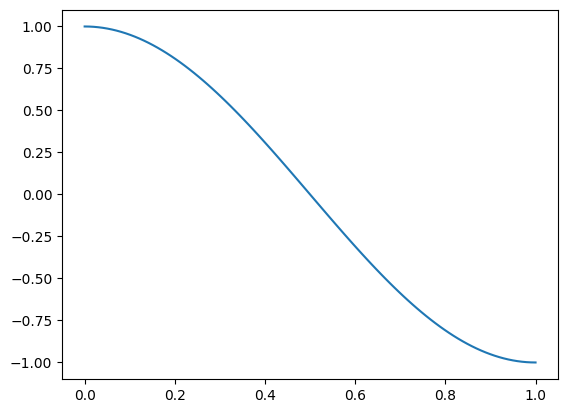

In [12]:
plot_func(lambda x: math.cos(math.pi * x), (0,  1))

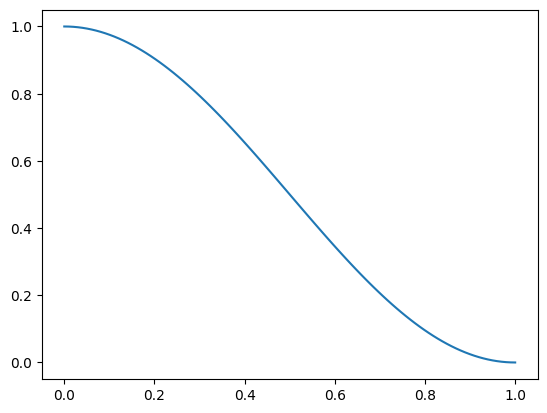

In [13]:
plot_func(lambda x: 0.5 * (1.0 + math.cos(math.pi * x)), (0,  1))

In [14]:
#| export
def get_lr(step, max_lr, min_lr, warmup_steps, max_steps):
    # linear warmup stage
    if step < warmup_steps:
        # there is no point of 0 lr even in the first step
        return max_lr * (step + 1) / warmup_steps

    # steps exceeding annealing stage are clamped to min_lr
    if step > max_steps:
        return min_lr

    # cosine decay
    decay_ratio = (step - warmup_steps) / (max_steps - warmup_steps)
    decay_ratio = min(max(0.0, decay_ratio), 1.0)
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coefficent starts from 1 and goes to 0

    return min_lr + (max_lr - min_lr) * coeff

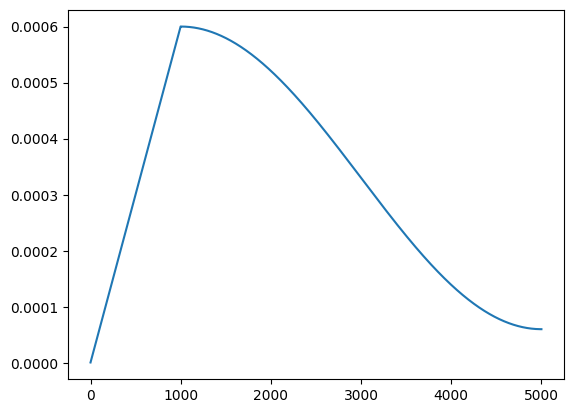

In [15]:
max_lr = 6e-4
min_lr = max_lr * 0.1
warmup_steps = 10
n = 50
plot_func(
    lambda x: partial(
        get_lr,
        max_lr=max_lr,
        min_lr=min_lr,
        warmup_steps=1000,
        max_steps=5000,
    )(x),
    (0, 5000),
    5000,
)

In [16]:
#| export
class CosineLR(torch.optim.lr_scheduler.LRScheduler):
    def __init__( self, optimizer, warmup_steps, max_steps, ratio=0.1, last_epoch=-1, verbose=False):
        self.max_lr = optimizer.param_groups[0]["lr"]
        self.min_lr = self.max_lr * ratio
        self.warmup_steps = warmup_steps
        self.max_steps = max_steps
        super().__init__(optimizer=optimizer, last_epoch=last_epoch, verbose=verbose)

    def get_lr(self):
        return [
            get_lr(
                self._step_count,
                self.max_lr,
                self.min_lr,
                self.warmup_steps,
                self.max_steps,
            )
            for base_lr in self.base_lrs
        ]

In [17]:
#| export
class ScheduleCB(Callback):

    def __init__(self, schedule_fn):
        self.schedule_fn = schedule_fn

    def before_fit(self, learn):
        self.sched = self.schedule_fn(learn.opt)

    def after_step(self, learn):
        # scheduler step after the optimizer step
        self.sched.step()

In [18]:
#| export
class RecordCB(Callback):

    def __init__(self, **d):
        # d is a dictionary of items to record and functions to calculate them
        self.d = d

    def before_fit(self, learn):
        self.recs = {k: [] for k in self.d.keys()}

    def after_batch(self, learn):
        if not learn.training:
            return
        for k, v in self.d.items():
            self.recs[k].append(v(self, learn))
    
    def plot(self):
        for k, v in self.recs.items():
            plt.plot(v, label=k)
            plt.legend()
            plt.show()

In [19]:
#| export
def get_learner_lr(cb, learn):
    return learn.opt.param_groups[0]['lr']

In [20]:
#| export
def get_learner_grad_norm(cb, learn):
    return learn.grad_nom.detach().cpu()

In [21]:
cbs = [NormGradTrainCB(), InitWeightsCB(), DeviceCB(), MetricsCB(), ProgressCB()]
def fit(model, epochs=1, opt_func=optim.AdamW, xtra_cbs=None, lr=3e-4):
    lrn = Learner(model, dls=dls, opt_func=opt_func, cbs=cbs + fc.L(xtra_cbs), lr=lr)
    lrn.fit(epochs, valid=False)
    return lrn

In [22]:
set_seed(1337)

In [23]:
model = get_model()
record = RecordCB(lr=get_learner_lr, grad_norm=get_learner_grad_norm)
schd = ScheduleCB(partial(CosineLR, warmup_steps=10, max_steps=50))
fit(model, opt_func=admw, xtra_cbs=[record, schd, TimeCallback()], lr=6e-4)

loss,epoch,train
7.143,0,train


step 0, loss: 10.96, time: 941.73msi, tok/sec: 2175
step 1, loss: 9.60, time: 157.46msi, tok/sec: 13006
step 2, loss: 9.12, time: 151.40msi, tok/sec: 13527
step 3, loss: 9.13, time: 152.27msi, tok/sec: 13450
step 4, loss: 9.10, time: 152.66msi, tok/sec: 13416
step 5, loss: 8.73, time: 150.85msi, tok/sec: 13576
step 6, loss: 8.65, time: 154.15msi, tok/sec: 13286
step 7, loss: 8.35, time: 156.35msi, tok/sec: 13099
step 8, loss: 8.10, time: 150.54msi, tok/sec: 13604
step 9, loss: 7.88, time: 153.14msi, tok/sec: 13374
step 10, loss: 7.39, time: 152.69msi, tok/sec: 13413
step 11, loss: 7.48, time: 151.64msi, tok/sec: 13506
step 12, loss: 7.20, time: 153.70msi, tok/sec: 13325
step 13, loss: 7.16, time: 153.71msi, tok/sec: 13324
step 14, loss: 6.82, time: 151.71msi, tok/sec: 13499
step 15, loss: 7.07, time: 153.60msi, tok/sec: 13333
step 16, loss: 6.56, time: 154.54msi, tok/sec: 13253
step 17, loss: 6.52, time: 152.03msi, tok/sec: 13471
step 18, loss: 6.42, time: 153.16msi, tok/sec: 13372
ste

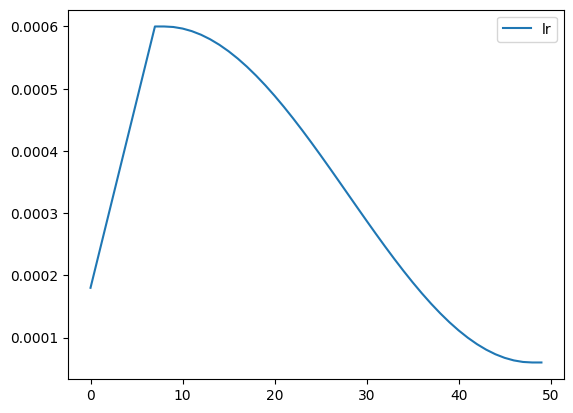

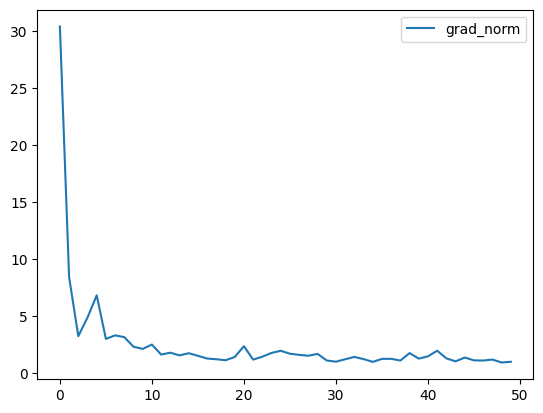

In [24]:
record.plot()

## Weight decay
> All models use weight decay of 0.1 to provide a small amount of regularization

Parameters should be considered as two groups: those should be weight decayed, and those should be not.

It is common to not apply weight decay to:
1. Biases
2. Any 1-D layers
3. LayerNorm

And apply weight decay to:
1. Weights that participate in matrix multiplication (typically linear layers)
2. Embeddings

Weight decay is a form of L2 regularization, and it is applied to the loss function as:
$$ L_{\text{total}} = L_{\text{loss}} + \lambda \sum_{i} w_i^2 $$
where $L_{\text{loss}}$ is the loss function, $\lambda$ is the weight decay rate, and $w_i$ are the weights that should be decayed.

In practice the optimizer updates the weights as:
$$ w_i = w_i - \alpha \frac{\partial L_{\text{loss}}}{\partial w_i} - \alpha \lambda w_i $$
where $\alpha$ is the learning rate.

And why is that?

Consider how we would update the weights in the optimizer:
$$ w_i = w_i - \alpha \frac{\partial L_{\text{total}}}{\partial w_i} $$
By adding the regularization term, if we take the derivative of the total loss with respect to the weights, we get:
$$ \frac{\partial L_{\text{total}}}{\partial w_i} = \frac{\partial L_{\text{loss}}}{\partial w_i} + \frac{\partial (\lambda \sum_{i} w_i^2)}{\partial w_i} $$
Since we are taking the partial derivative of the sum with respect to $w_i$, other weights has no effect on the derivative, so we get: $2 \lambda w_i$ and $\lambda$ is just a constant, so we can simply make it twice as big.

In [25]:
for pn, p in model.named_parameters():
    print(pn, p.shape)

transformer.wte.weight torch.Size([50304, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([2304, 768])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([2304, 768])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

In [26]:
param_dict = {pn: p for pn, p in model.named_parameters()}
param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
num_decay_params = sum(p.numel() for p in decay_params)
num_nodecay_params = sum(p.numel() for p in nodecay_params)
print(
    f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters"
)
print(
    f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters"
)

num decayed parameter tensors: 50, with 124,354,560 parameters
num non-decayed parameter tensors: 98, with 121,344 parameters


In [27]:
params = list(model.parameters())
decay_params = [p for p in params if p.dim() >= 2]
nodecay_params = [p for p in params if p.dim() < 2]
num_decay_params = sum(p.numel() for p in decay_params)
num_nodecay_params = sum(p.numel() for p in nodecay_params)
print(
    f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters"
)
print(
    f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters"
)

num decayed parameter tensors: 50, with 124,354,560 parameters
num non-decayed parameter tensors: 98, with 121,344 parameters


In [28]:
del model
clean_mem()

In [29]:
#| export
import inspect

use_fused_adam = (
    "cuda" == default_device and "fused" in inspect.signature(optim.AdamW).parameters
)

In [30]:
use_fused_adam

True

In [31]:
#| export
def get_optimizer(params, lr, weight_decay=0.1, fused=True):
    params = [p for p in params if p.requires_grad]
    decay_params = [p for p in params if p.dim() >= 2]
    nodecay_params = [p for p in params if p.dim() < 2]
    optim_groups = [
        {'params': decay_params, 'weight_decay': weight_decay},
        {'params': nodecay_params, 'weight_decay': 0.0}
    ]
    return optim.AdamW(optim_groups, lr=lr, betas=(0.9, 0.95), eps=1e-8, fused=fused) 

In [32]:
# fused adam requires parameters to be on cuda, move model to cuda before creating optimizer
model = get_model().to(default_device)
record = RecordCB(lr=get_learner_lr, grad_norm=get_learner_grad_norm)
schd = ScheduleCB(partial(CosineLR, warmup_steps=10, max_steps=50))
fit(model, opt_func=get_optimizer, xtra_cbs=[record, schd], lr=6e-4)

loss,epoch,train
7.203,0,train


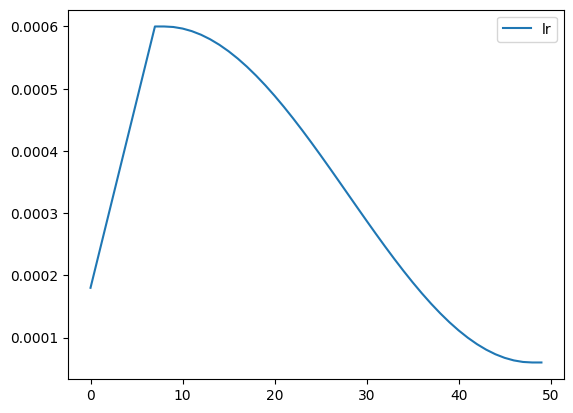

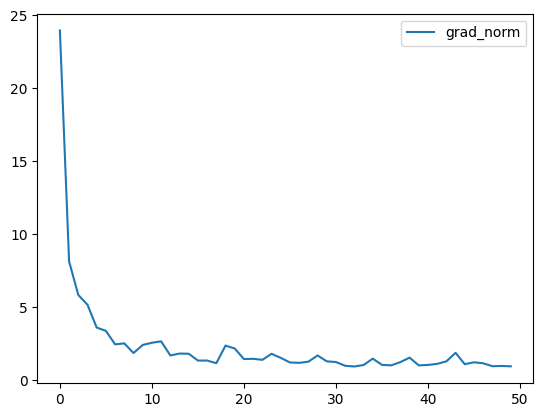

In [33]:
record.plot()

In [34]:
del model
clean_mem()

## Gradient accumulate

According to GPT-3 paper, the use batch size of 0.5M tokens. That is impossible to fit into our setting. We can use a technique called gradient accumulation to simulate a larger batch size.
The idea is that we run forward and backward passes for multiple batches, each time we run backward pass the gradients are accumulated, after a certain number of batches we update the weights. This way we can simulate a larger batch size without running out of memory.

In [35]:
net = nn.Sequential(nn.Linear(16, 32), nn.GELU(), nn.Linear(32, 1))
xs = torch.randn(4, 16)
ys = torch.randn(4, 1)
loss_func = nn.MSELoss()

In [36]:
net.zero_grad()
preds = net(xs)
loss = loss_func(preds, ys)
loss.backward()

print(net[0].weight.grad[0])

tensor([-0.0601, -0.1094,  0.0453,  0.0095,  0.0042,  0.0474,  0.1012, -0.0933,
        -0.1347,  0.0615,  0.1037,  0.0408, -0.0361,  0.0024,  0.0179, -0.0156])


In [37]:
net.zero_grad()
for i in range(4):
    preds = net(xs[i])
    loss = loss_func(preds, ys[i])
    loss.backward()

print(net[0].weight.grad[0])

tensor([-0.2405, -0.4375,  0.1813,  0.0381,  0.0170,  0.1896,  0.4049, -0.3733,
        -0.5387,  0.2462,  0.4147,  0.1632, -0.1443,  0.0097,  0.0715, -0.0624])


These two gradients are not equal, the latter is roughly 4x, why is that?
Take a look at the loss function signature:
```
nn.MSELoss(size_average=None, reduce=None, reduction: str = 'mean') -> None
```
The default value for `reduction` is `'mean'`, which means the loss is averaged over all the samples. In the second case the normalizer is lost.

In [38]:
net.zero_grad()
for i in range(4):
    preds = net(xs[i])
    loss = loss_func(preds, ys[i]) / 4
    loss.backward()

print(net[0].weight.grad[0])

tensor([-0.0601, -0.1094,  0.0453,  0.0095,  0.0042,  0.0474,  0.1012, -0.0933,
        -0.1347,  0.0615,  0.1037,  0.0408, -0.0361,  0.0024,  0.0179, -0.0156])


By add normalization to the loss function, the normalizer is distributed to the gradients and makes them equal.

In [39]:
# | export
class GradAccuTrainCB(MixedPrecisionTrainCB):

    def __init__(self, accu_steps=1):
        self.accu_steps = accu_steps

    def before_fit(self, learn):
        learn._micro_step_count = 0
        learn.accu_steps = self.accu_steps

    def after_predict(self, learn):
        learn.loss = learn.loss / self.accu_steps
        learn._micro_step_count += 1

    def after_backward(self, learn):
        if learn._micro_step_count % learn.accu_steps == 0:
            learn.grad_nom = nn.utils.clip_grad_norm_(learn.model.parameters(), 1.0)

    def step(self, learn):
        if learn._micro_step_count % learn.accu_steps == 0:
            super().step(learn)

    def zero_grad(self, learn):
        if learn._micro_step_count % learn.accu_steps == 0:
            super().zero_grad(learn)

In [40]:
#| export
class GradAccuScheduleCB(Callback):

    def __init__(self, schedule_fn):
        self.schedule_fn = schedule_fn

    def before_fit(self, learn):
        self.sched = self.schedule_fn(learn.opt)

    def after_step(self, learn):
        if hasattr(learn, "accu_steps"):
            if learn._micro_step_count % learn.accu_steps == 0:
               self.sched.step()
        else:
            self.sched.step()

In [41]:
#| export
class GradAccuRecordCB(Callback):

    def __init__(self, **d):
        # d is a dictionary of items to record and functions to calculate them
        self.d = d

    def before_fit(self, learn):
        self.recs = {k: [] for k in self.d.keys()}

    def after_batch(self, learn):
        if not learn.training:
            return
        if hasattr(learn, "accu_steps"):
            if learn._micro_step_count % learn.accu_steps != 0:
                return
        for k, v in self.d.items():
            self.recs[k].append(v(self, learn))
    
    def plot(self):
        for k, v in self.recs.items():
            plt.plot(v, label=k)
            plt.legend()
            plt.show()

In [42]:
# | export
class GradAccuLogCallback(Callback):
    def __init__(self, **d) -> None:
        self.d = d

    def before_fit(self, learn):
        # self.recs = {k: [] for k in self.d.keys()}
        self.reset()

    def before_batch(self, learn):
        if learn._micro_step_count % learn.accu_steps != 0:
            return
        self.t0 = time.time()
        self.loss_accu = 0

    def _log(self, d):
        d = {k: f"{v:.4f}" if not isinstance(v, str) else v for k, v in d.items()}
        print(d)

    def reset(self):
        self.loss_accu = 0

    def after_batch(self, learn):
        self.loss_accu += learn.loss.detach()
        if learn._micro_step_count % learn.accu_steps != 0:
            return
        torch.cuda.synchronize()  # wait for the GPU to finish work
        self.t1 = time.time()

        log = {
            "step": f"{learn.opt._step_count: 5d}",
            "time": f"{(self.t1 - self.t0) * 1000:.2f}",
        }
        log.update({k: v(self, learn) for k, v in self.d.items()})
        self._log(log)
        self.reset()

In [43]:
def get_learner_loss(cb, learn):
    return cb.loss_accu

def get_tokens_per_sec(cb, learn):
    x, _ = learn.batch
    return x.shape[0] * x.shape[1] / (cb.t1 - cb.t0) * learn.accu_steps

In [44]:
tds = LoopingDataSet(torch.tensor(train), n=5000, T=1024)
# vds = DataSet(torch.tensor(valid))
dls = DataLoaders.from_dd([tds, None], batch_size=8)
x, y = next(iter(dls.train))
x.shape, y.shape, len(tds), len(dls.train)

(torch.Size([8, 1024]), torch.Size([8, 1024]), 5000, 625)

we are doing 8 * 1024 = 8192 tokens per batch, so we can accumulate the gradients for 64 batches to simulate a batch size of 0.5M tokens.

In [45]:
grad_accu_steps = 50
cbs = [GradAccuTrainCB(grad_accu_steps), InitWeightsCB(), CompileCB(), DeviceCB()]
model = get_model().to(default_device)
record = GradAccuRecordCB(lr=get_learner_lr, grad_norm=get_learner_grad_norm)
schd = GradAccuScheduleCB(partial(CosineLR, warmup_steps=10, max_steps=50))
logcb = GradAccuLogCallback(
    **{
        "loss": lambda cb, learn: f"{get_learner_loss(cb, learn):2.6f}",
        "lr": lambda cb, learn: f"{get_learner_lr(cb ,learn):.4e}",
        "norm": get_learner_grad_norm,
        "tok/sec": get_tokens_per_sec,
    }
)
fit(model, opt_func=get_optimizer, xtra_cbs=[record, schd, logcb], lr=6e-4)

{'step': '    1', 'time': '36359.94', 'loss': '10.968640', 'lr': '1.8000e-04', 'norm': '20.6479', 'tok/sec': '11265.1442'}
{'step': '    2', 'time': '19807.88', 'loss': '9.481111', 'lr': '2.4000e-04', 'norm': '6.8205', 'tok/sec': '20678.6423'}
{'step': '    3', 'time': '19880.40', 'loss': '9.502487', 'lr': '3.0000e-04', 'norm': '7.1634', 'tok/sec': '20603.2075'}
{'step': '    4', 'time': '19883.75', 'loss': '9.096238', 'lr': '3.6000e-04', 'norm': '3.5590', 'tok/sec': '20599.7330'}
{'step': '    5', 'time': '19814.23', 'loss': '9.057843', 'lr': '4.2000e-04', 'norm': '3.6954', 'tok/sec': '20672.0078'}
{'step': '    6', 'time': '19711.80', 'loss': '8.995171', 'lr': '4.8000e-04', 'norm': '3.8594', 'tok/sec': '20779.4365'}
{'step': '    7', 'time': '19530.56', 'loss': '8.927704', 'lr': '5.4000e-04', 'norm': '3.7689', 'tok/sec': '20972.2601'}
{'step': '    8', 'time': '19339.37', 'loss': '8.810529', 'lr': '6.0000e-04', 'norm': '3.8119', 'tok/sec': '21179.5932'}
{'step': '    9', 'time': '193

In [47]:
del model
clean_mem()

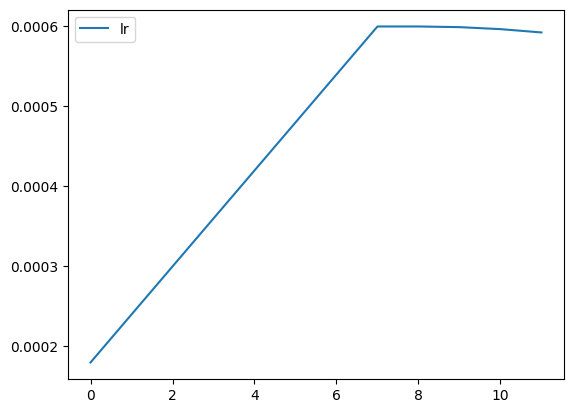

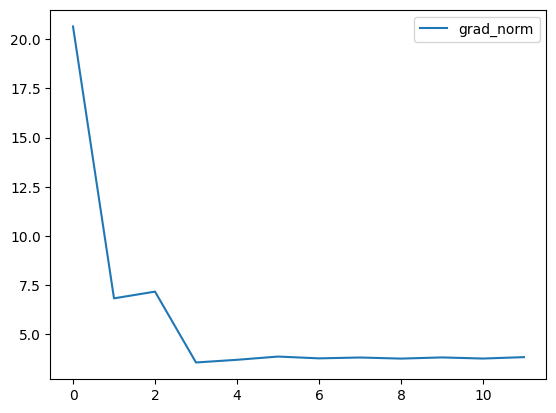

In [48]:
record.plot()